<a href="https://colab.research.google.com/github/ivan74rus/MTS-ML-CUP/blob/v3-scor-1.6539/MTS_CUP_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##import

In [ ]:
#подключить гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#instal catboost
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import joblib
import numpy as np
#from random import randint
#import time
import pyarrow.parquet as pq
#import scipy
#import bisect
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
#from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [ ]:
# константы
LOCAL_DATA_PATH = '/content/drive/MyDrive/DS/MTS/'
LOCAL_DATA_PATH_2 = '/content/drive/MyDrive/DS/MTS/feat_select/'
#SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TIM_LIST = 'timur_url_list_1.csv' #'top_all_urls_2802.xlsx'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit_2.pqt'



# 1.Загружаем в пандус кусок  и готовим для ML.
 Так как ОЗУ всего 12 Гигов и не хватает, то будем выдергивать нужные фичи по кускам, сохранять все на диск  и затем с диска снова подгружать.    

  

### 1.0. Условие на нужные урлы 
 
так назвывается псписко для отсева урлов 


In [ ]:
#Общиие урлы для age  and male
#2700 не хватает памяти на сшивку, 2500 ок
timur_url_list = pd.read_csv(f'{LOCAL_DATA_PATH}top_all_urls.csv')
timur_url_list = timur_url_list.reset_index(drop=True).loc[7501:15000,'index'].values

len(timur_url_list)
#timur_url_list

7500

In [ ]:
# это фичи из фич_импотант
timur_url_list_age = pd.read_csv(f'{LOCAL_DATA_PATH}feature_age_importance_5.csv')
timur_url_list_male = pd.read_csv(f'{LOCAL_DATA_PATH}feature_male_importance_5.csv')

timur_url_list_age_2 = pd.read_csv(f'{LOCAL_DATA_PATH}feature_age_importance_2.csv')
timur_url_list_male_2 = pd.read_csv(f'{LOCAL_DATA_PATH}feature_male_importance_2.csv')

#сложеие 2х списков
#timur_url_list_age = set (timur_url_list_age['index']) | set(timur_url_list_age_2['index'])
#timur_url_list_male = set (timur_url_list_male['index']) |  set(timur_url_list_male_2['index'])

# раздельно
timur_url_list_age = timur_url_list_age.loc[:,'index'].values
timur_url_list_male = timur_url_list_male.loc[:,'index'].values



In [ ]:
#тут и ниже склейка фич_им и фич_имп найденных на рандом циклах


feature_importance_list = [
   '977070',
   '79457',
   #'79867',

]
#cсозд пуст дф
feature_importance_age = pd.read_csv(f'{LOCAL_DATA_PATH_2}feature_age_importance_79867.csv') 
feature_importance_male = pd.read_csv(f'{LOCAL_DATA_PATH_2}feature_male_importance_79867.csv')
# подкгрузка и склека
for i in feature_importance_list:
  feature_importance_age_ = pd.read_csv(f'{LOCAL_DATA_PATH_2}feature_age_importance_{i}.csv') 
  feature_importance_male_ = pd.read_csv(f'{LOCAL_DATA_PATH_2}feature_male_importance_{i}.csv')

  feature_importance_age = pd.concat([feature_importance_age, feature_importance_age_], ignore_index=True)
  feature_importance_male = pd.concat([feature_importance_male, feature_importance_male_], ignore_index=True)
  print (i)

  #feature_importance_age = feature_importance_age.rename(columns={'index' :'url', '0':'feat_imp' }) 
  #feature_importance_male = feature_importance_male.rename(columns={'index' :'url', '0':'feat_imp' }) 

timur_url_list_age_v2 = feature_importance_age.pivot_table(index='index', values='0', aggfunc='sum').sort_values(by='0',ascending=False).reset_index()['index'].head(1200).values
timur_url_list_male_v2 = feature_importance_male.pivot_table(index='index', values='0', aggfunc='sum').sort_values(by='0',ascending=False).reset_index()['index'].head(1200).values




timur_url_list_age_v1 = set (timur_url_list_age)
timur_url_list_male_v1 = set (timur_url_list_male)

timur_url_list_age_v2 = set (timur_url_list_age_v2)
timur_url_list_male_v2 = set (timur_url_list_male_v2)

timur_url_list_age = timur_url_list_age_v1 | timur_url_list_age_v2
timur_url_list_male = timur_url_list_male_v1 | timur_url_list_male_v2

977070
79457


In [ ]:
print(len (timur_url_list_age))
print(len(timur_url_list_male))

1313
1075


In [ ]:
#сабмиты и таргеты
#сразу дропаем ненужный возраст из таргет
id_for_target = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}').to_pandas().query('age >=19 ') 
id_for_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas() 
# подготовленый user_id  city
user_city = pd.read_csv(f'{LOCAL_DATA_PATH}/user_city.csv')

In [1]:
#функция разбивки возраста по категориям
#def age_bucket(x):
#    return bisect.bisect_left([19,25,35,45,55,65], x)

#my fucnk
def age_bascket(x):
  if x <= 25 :
    return 1
  elif 25 < x <= 35:
    return 2
  elif 35 < x <= 45:
    return 3
  elif 45 < x <= 55:
    return 4
  elif 55 < x <= 65:
    return 5
  return 6  

# ОС 
def os_type(x):
  if (x ==  'Apple iOS') or (x ==  'iOS'):
    return 1
  return 0

#bisect.bisect_right([19,26,36,46,56,66], x) # вроде так надо пишут

## Цикл 1 Загружаем из паркета ЦИКЛОМ нужные фичи и обрабатываем кусок.
Формируем часть дф готового к обработке, сохраняем на диск уже раздельно трайн и фо_сабмит выбокри. Все дял экономии памяти ОЗУ. Все разбивки  и сохраннеия все в цикле. Иначе финальный кусок не оббработать никак.

In [ ]:
part_list  = ['part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00008-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00009-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
   
]

In [2]:
# Это цикл совместный  age  male урлы одинаковы и берутся из списка топ урлов
# цикл грузит из паркета нужные даные и отсеивает по топ урлам из списка
for i in   range(0,10): #[0,5]
  
  #тут выбираем какие колонки из паркета грузим, можно через переменну определить
  # 'cpe_model_name' 'cpe_manufacturer_name',
  df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[i]}').select([	'cpe_model_name', 'cpe_model_os_type', 'url_host',		'request_cnt',	'part_of_day','user_id']).to_pandas()
  
  #контроль цикла, загрузка из паркета в память.
  print ('part', i, 'load, shape = ',df.shape)
  # для подсчета соко пропало user_id после обрезки по урлам
  user_id_count = df['user_id'].nunique()
  print ('part', i, 'до обрезки user_id = ', df['user_id'].nunique())

  # дф по времени суток / нужно это делать на всем дф, со всеми урлами
  df_user_part_of_day = df.pivot_table(index='user_id', columns='part_of_day', values='request_cnt',aggfunc='count').reset_index()

  #обрезаем по урлам
  df = df.query('url_host in @timur_url_list')
  # урлы user_id кто не пользуются топ 2к сайтами. сначала надо их обрабоатть
  #df_freaks = df.query('url_host not in @timur_url_list')
  #df_freaks.reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}df_freak_part_{i}.feather')


  print ('part', i, 'load, shape после обрезки урлов = ',df.shape)
  print ('part', i, 'после обрезки user_id уменьшилось на :',  user_id_count - df['user_id'].nunique())
  # дф по урлам формируем 
  df_user_url = df.pivot_table(index='user_id', columns='url_host', values='request_cnt',aggfunc='count').reset_index()

  #обезаем дф до состояния каждый юзер 1 строчка
  df.drop(columns=['url_host', 'request_cnt', 'part_of_day'], inplace=True)
  df.drop_duplicates(inplace=True)
  
 
  #объедение с выкидыванием юзеров фриков

  print ('df_user_part_of_day.shape',df_user_part_of_day.shape )
  df = df.merge(df_user_part_of_day, on='user_id')
  print ('после .merge',df.shape)
  df = df.merge(df_user_url, how='outer', on='user_id')
  print ('после всех merge размерность df',df.shape)
  
  # кэт ругается на нан
  df.loc[df['cpe_model_name'].isna() ,'cpe_model_name'] = '0'

  #теперь разделяем на train submit 
  df_train = df.merge(id_for_target,  on='user_id')
  df_submit = df.merge(id_for_submit, on='user_id')

  
  #дропаем возраст <19  сразу тут из  трайн (убирается в merge)
  #df_train = df_train[df_train['age'] >=19] 
  
  #категоризируем возраст - заменна функция на мою
  df_train['age'] = df_train['age'].map(age_bascket)
  
  #сохраняем на диск  подготовленные файлы
  #########################################
  df_train.reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_part_{i}.feather')
  df_submit.to_feather(f'{LOCAL_DATA_PATH}submit_part_{i}.feather')

  # все заранее разбиваем, т к потом не хватает ОЗУ общий файл обрабатывать
  
  # сохраняем фичи и таргет для age
  df_train.drop(['user_id', 'age', 'is_male'], axis = 1).reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_feat_age_part_{i}.feather') #,index = False)
  #df_train.drop(['user_id', 'age', 'is_male'], axis = 1).to_csv(f'{LOCAL_DATA_PATH}train_feat_age_part_{i}.csv' ,index = False)
  df_train['age'].to_csv(f'{LOCAL_DATA_PATH}train_target_age_part_{i}.csv', index = False)
    

  # сохраняем фичи и таргет для is_male
  #дропаем перед ML по полу, заранее нельзя, тк  там много данных по возрасту
  print ('df_train.shape до обрезки is_male != NA',df_train.shape )
  df_train = df_train[df_train['is_male'] != 'NA']
  print ('df_train.shape ПОСЛЕ обрезки is_male != NA',df_train.shape )
  
  df_train.drop(['user_id', 'age', 'is_male'], axis = 1).reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_feat_is_male_part_{i}.feather')
  df_train['is_male'].to_csv(f'{LOCAL_DATA_PATH}train_target_is_male_part_{i}.csv', index = False)


  #итого сохраняется файл сабмита + общий_трайн + фич+таргет_age + фич+таргет_is_male = 6шт
  # все нужно для анализа

  print ('part' , i , 'saved on disc')

NameError: ignored

## Цикл 2, age & male раздельно по урлам, на основе features_important

In [ ]:
# цикл грузит из паркета нужные даные и отсеивает по топ урлам из списка

#'cpe_manufacturer_name',
features_for_load = [	'cpe_model_name', 'cpe_model_os_type', 'url_host', 'request_cnt',	'part_of_day','user_id']
for i in     range(0,10):
#for i in     [0,5]:  
  #тут выбираем какие колонки из паркета грузим, можно через переменну определить
  # 'cpe_model_name' 'cpe_manufacturer_name', ,'cpe_model_os_type'
  df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[i]}').select(features_for_load).to_pandas()
  
  #контроль цикла, загрузка из паркета в память.
  print ('part', i, 'load, shape = ',df.shape)
  #
  df['cpe_model_os_type'] = df['cpe_model_os_type'].map(os_type)
  # для подсчета соко пропало user_id после обрезки по урлам
  user_id_count = df['user_id'].nunique()
  print ('part', i, 'до обрезки user_id = ', df['user_id'].nunique())

  # дф по времени суток / нужно это делать на всем дф, со всеми урлами
  df_user_part_of_day = df.pivot_table(index='user_id', columns='part_of_day', values='request_cnt',aggfunc='count').reset_index()

  #обрезаем по урлам
  df_age = df.query('url_host in @timur_url_list_age')
  df_male= df.query('url_host in @timur_url_list_male')
  #удаляем пременную для экономии паммяти
  del df

  print ('part', i, 'после обрезки user_id age уменьшилось на :',  user_id_count - df_age['user_id'].nunique())
  print ('part', i, 'после обрезки user_id  male уменьшилось на :',  user_id_count - df_male['user_id'].nunique())

  # дф по урлам формируем 
  df_user_url_age = df_age.pivot_table(index='user_id', columns='url_host', values='request_cnt',aggfunc='count').reset_index()
  df_user_url_male = df_male.pivot_table(index='user_id', columns='url_host', values='request_cnt',aggfunc='count').reset_index()

  #обезаем дф до состояния каждый юзер 1 строчка
  df_age.drop(columns=['url_host', 'request_cnt', 'part_of_day'], inplace=True)
  df_age.drop_duplicates(inplace=True)
  df_male.drop(columns=['url_host', 'request_cnt', 'part_of_day'], inplace=True)
  df_male.drop_duplicates(inplace=True)
 
  #объедение 
  
  df_age = df_age.merge(df_user_part_of_day, on='user_id')
  df_male = df_male.merge(df_user_part_of_day, on='user_id')
  del df_user_part_of_day

  df_age = df_age.merge(df_user_url_age,  on='user_id')
  del df_user_url_age
  df_male = df_male.merge(df_user_url_male, on='user_id')
  del df_user_url_male
  
  #df_age = df_age.merge(user_city,  on='user_id')
  #df_male = df_male.merge(user_city,  on='user_id')
  
  print ('после всех merge размерность df_age = ',df_age.shape)
  print ('после всех merge размерность df_male = ',df_male.shape)
  
  
  # кэт ругается на нан
  df_age.loc[df_age['cpe_model_name'].isna() ,'cpe_model_name'] = '0'
  df_male.loc[df_male['cpe_model_name'].isna() ,'cpe_model_name'] = '0'

  #теперь разделяем на train submit 
  
  df_submit_age = df_age.merge(id_for_submit, on='user_id')
  df_submit_male = df_male.merge(id_for_submit, on='user_id')
  df_submit_age.to_feather(f'{LOCAL_DATA_PATH}submit_age_part_{i}.feather')
  df_submit_male.to_feather(f'{LOCAL_DATA_PATH}submit_male_part_{i}.feather')
  del df_submit_age
  del df_submit_male

  df_train_age = df_age.merge(id_for_target,  on='user_id')
  df_train_male = df_male.merge(id_for_target,  on='user_id')
  del df_age
  del df_male 
  
  #категоризируем возраст -
  df_train_age['age'] = df_train_age['age'].map(age_bascket)
  
  #сохраняем на диск  подготовленные файлы
  #########################################
  df_train_age.reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_age_part_{i}.feather')
  df_train_male.reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_male_part_{i}.feather')

  # все заранее разбиваем, т к потом не хватает ОЗУ общий файл обрабатывать
  
  # сохраняем фичи и таргет для age
  df_train_age.drop(['user_id', 'age', 'is_male'], axis = 1).reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_feat_age_part_{i}.feather') #,index = False)
  df_train_age['age'].to_csv(f'{LOCAL_DATA_PATH}train_target_age_part_{i}.csv', index = False)
    

  # сохраняем фичи и таргет для is_male
  #дропаем перед ML по полу
  df_train_male = df_train_male[df_train_male['is_male'] != 'NA']
  
  
  df_train_male.drop(['user_id', 'age', 'is_male'], axis = 1).reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_feat_is_male_part_{i}.feather')
  df_train_male['is_male'].to_csv(f'{LOCAL_DATA_PATH}train_target_is_male_part_{i}.csv', index = False)

  print ('part' , i , 'saved on disc')
  del df_train_age
  del df_train_male


part 0 load, shape =  (32638709, 6)
part 0 до обрезки user_id =  41594
part 0 после обрезки user_id age уменьшилось на : 4
part 0 после обрезки user_id  male уменьшилось на : 6
после всех merge размерность df_age =  (41590, 1314)
после всех merge размерность df_male =  (41588, 1082)
part 0 saved on disc
part 1 load, shape =  (32423119, 6)
part 1 до обрезки user_id =  41570
part 1 после обрезки user_id age уменьшилось на : 5
part 1 после обрезки user_id  male уменьшилось на : 6
после всех merge размерность df_age =  (41565, 1314)
после всех merge размерность df_male =  (41564, 1082)
part 1 saved on disc
part 2 load, shape =  (32146620, 6)
part 2 до обрезки user_id =  41335
part 2 после обрезки user_id age уменьшилось на : 5
part 2 после обрезки user_id  male уменьшилось на : 7
после всех merge размерность df_age =  (41330, 1314)
после всех merge размерность df_male =  (41328, 1082)
part 2 saved on disc
part 3 load, shape =  (32156858, 6)
part 3 до обрезки user_id =  41640
part 3 после о

## Цикл 2.2  Сначала age потом male

In [3]:
# пока не дописан/ не отлажен, тк не потребовался
# цикл  РАЗДЕЛЬНО грузит из паркета нужные даные и отсеивает по топ урлам из списка
features_for_load = [	'cpe_model_name', 'cpe_model_os_type','cpe_manufacturer_name', 'url_host', 'request_cnt',	'part_of_day','user_id']
for i in     range(0,10):
#for i in     [0,5]:  
  #тут выбираем какие колонки из паркета грузим, можно через переменну определить
  # 'cpe_model_name' 'cpe_manufacturer_name', ,'cpe_model_os_type'
  df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[i]}').select(features_for_load).to_pandas()
  
  df.loc[df['cpe_model_os_type'] == 'Apple iOS','cpe_model_os_type' ] = 'iOS' 
  #контроль цикла, загрузка из паркета в память.
  print ('part', i, 'load, shape = ',df.shape)
  # для подсчета соко пропало user_id после обрезки по урлам
  user_id_count = df['user_id'].nunique()
  print ('part', i, 'до обрезки user_id = ', df['user_id'].nunique())

  # дф по времени суток / нужно это делать на всем дф, со всеми урлами
  df_user_part_of_day = df.pivot_table(index='user_id', columns='part_of_day', values='request_cnt',aggfunc='count').reset_index()

  #обрезаем по урлам
  df_age = df.query('url_host in @timur_url_list_age')
  #удаляем пременную для экономии паммяти
  del df
  print ('part', i, 'после обрезки user_id age уменьшилось на :',  user_id_count - df_age['user_id'].nunique())
  # дф по урлам формируем 
  df_user_url_age = df_age.pivot_table(index='user_id', columns='url_host', values='request_cnt',aggfunc='count').reset_index()
  
  #обезаем дф до состояния каждый юзер 1 строчка
  df_age.drop(columns=['url_host', 'request_cnt', 'part_of_day'], inplace=True)
  df_age.drop_duplicates(inplace=True)
   
  #объедение 
  df_age = df_age.merge(df_user_part_of_day, on='user_id')
  df_age = df_age.merge(df_user_url_age,  on='user_id')
  df_age = df_age.merge(user_city, on='user_id')
  print ('после всех merge размерность df_age = ',df_age.shape)
  del df_user_part_of_day
  del df_user_url_age 

  # кэт ругается на нан
  df_age.loc[df_age['cpe_model_name'].isna() ,'cpe_model_name'] = '0'
  
  #теперь разделяем на train submit 
  df_submit_age = df_age.merge(id_for_submit, on='user_id')
  df_submit_age.to_feather(f'{LOCAL_DATA_PATH}submit_age_part_{i}.feather')
  del   df_submit_age

  df_train_age = df_age.merge(id_for_target,  on='user_id')
  del df_age
    
  #категоризируем возраст - заменна функция на мою
  df_train_age['age'] = df_train_age['age'].map(age_bascket)
  
  #сохраняем на диск  подготовленные файлы
  #########################################

  
  df_train_age.to_feather(f'{LOCAL_DATA_PATH}train_age_part_{i}.feather') #.reset_index(drop=True)
  print (f'train_age_part_{i}.feather saved on disc')
  


  # сохраняем фичи и таргет для age
  df_train_age.drop(['user_id', 'age', 'is_male'], axis = 1).reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_feat_age_part_{i}.feather') #,index = False)
  df_train_age['age'].to_csv(f'{LOCAL_DATA_PATH}train_target_age_part_{i}.csv', index = False)
   
  print ('part age' , i , 'saved on disc')
  del df_train_age
  
  ######### is male ##########
    
  df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[i]}').select(features_for_load).to_pandas()
  
  # дф по времени суток / нужно это делать на всем дф, со всеми урлами
  df_user_part_of_day = df.pivot_table(index='user_id', columns='part_of_day', values='request_cnt',aggfunc='count').reset_index()

  #обрезаем по урлам
  df_male= df.query('url_host in @timur_url_list_male')
  #удаляем пременную для экономии паммяти
  del df

  print ('part', i, 'после обрезки user_id  male уменьшилось на :',  user_id_count - df_male['user_id'].nunique())

  # дф по урлам формируем 
  
  df_user_url_male = df_male.pivot_table(index='user_id', columns='url_host', values='request_cnt',aggfunc='count').reset_index()

  #обезаем дф до состояния каждый юзер 1 строчка
  df_male.drop(columns=['url_host', 'request_cnt', 'part_of_day'], inplace=True)
  df_male.drop_duplicates(inplace=True)

  #объеденение 
  df_male = df_male.merge(df_user_part_of_day, on='user_id')
  del df_user_part_of_day
  df_male = df_male.merge(df_user_url_male,  on='user_id')
  del df_user_url_male
  df_male = df_male.merge(user_city,  on='user_id')
  print ('после всех merge размерность df_male = ',df_male.shape)
    
  # кэт ругается на нан
  df_male.loc[df_male['cpe_model_name'].isna() ,'cpe_model_name'] = '0'

  #теперь разделяем на train submit 
  df_train_male = df_male.merge(id_for_target,  on='user_id')
  df_submit_male = df_male.merge(id_for_submit, on='user_id')
  #удаляем для экономии памати
  del df_age
  del df_male 
  
   
  #сохраняем на диск  подготовленные файлы
  #########################################
  df_train_male.reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_male_part_{i}.feather')
  df_submit_male.to_feather(f'{LOCAL_DATA_PATH}submit_male_part_{i}.feather')
  del df_submit_male

  #дропаем перед ML по полу
  df_train_male = df_train_male[df_train_male['is_male'] != 'NA']
    
  df_train_male.drop(['user_id', 'age', 'is_male'], axis = 1).reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_feat_is_male_part_{i}.feather')
  df_train_male['is_male'].to_csv(f'{LOCAL_DATA_PATH}train_target_is_male_part_{i}.csv', index = False)

  print ('part' , i , 'saved on disc')
  del df_train_male
  #конец итерации




NameError: ignored

In [ ]:

 # цикл  РАЗДЕЛЬНО грузит из паркета нужные даные и отсеивает по топ урлам из списка
features_for_load = [	'cpe_model_name', 'cpe_model_os_type','cpe_manufacturer_name', 'url_host', 'request_cnt',	'part_of_day','user_id']
for i in     range(0,1):
#for i in     [0,5]:  
  #тут выбираем какие колонки из паркета грузим, можно через переменну определить
  # 'cpe_model_name' 'cpe_manufacturer_name', ,'cpe_model_os_type'
  df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[i]}').select(features_for_load).to_pandas()
  df.loc[df['cpe_model_os_type'] == 'Apple iOS','cpe_model_os_type' ] = 'iOS' 
  #контроль цикла, загрузка из паркета в память.
  print ('part', i, 'load, shape = ',df.shape)
  # для подсчета соко пропало user_id после обрезки по урлам
  user_id_count = df['user_id'].nunique()
  print ('part', i, 'до обрезки user_id = ', df['user_id'].nunique())

  # дф по времени суток / нужно это делать на всем дф, со всеми урлами
  df_user_part_of_day = df.pivot_table(index='user_id', columns='part_of_day', values='request_cnt',aggfunc='count').reset_index()

  #обрезаем по урлам
  df_age = df.query('url_host in @timur_url_list_age')
  #удаляем пременную для экономии паммяти
  del df
  print ('part', i, 'после обрезки user_id age уменьшилось на :',  user_id_count - df_age['user_id'].nunique())
  # дф по урлам формируем 
  df_user_url_age = df_age.pivot_table(index='user_id', columns='url_host', values='request_cnt',aggfunc='count').reset_index()
  
  #обезаем дф до состояния каждый юзер 1 строчка
  df_age.drop(columns=['url_host', 'request_cnt', 'part_of_day'], inplace=True)
  df_age.drop_duplicates(inplace=True)
     
 

part 0 load, shape =  (32638709, 7)
part 0 до обрезки user_id =  41594
part 0 после обрезки user_id age уменьшилось на : 4


In [ ]:
 #объедение 
#df_age = df_age.merge(df_user_part_of_day, on='user_id')
#df_age = df_age.merge(df_user_url_age, on='user_id')
df_age = df_age.merge(user_city, on='user_id') # , how='outer'
#print ('после всех merge размерность df_age = ',df_age.shape)
#del df_user_part_of_day
#del df_user_url_age 


In [ ]:
df_age.shape

(41590, 1654)

In [ ]:
user_city.shape

(415317, 2)

In [ ]:
df_user_part_of_day.shape

(41594, 5)

In [ ]:
df_user_url_age.shape

(41590, 1646)

In [ ]:
df_age.loc[df_age['cpe_model_os_type'] == 'Apple iOS','cpe_model_os_type' ] = 'iOS' 
df_age['cpe_model_os_type'].unique()

array(['iOS', 'Android'], dtype=object)

In [ ]:
df_age['user_id'].value_counts().head(5)

45098     1
246802    1
3123      1
63877     1
170281    1
Name: user_id, dtype: int64

In [ ]:
df_age

,cpe_model_name,cpe_model_os_type,cpe_manufacturer_name,user_id,day,evening,morning,night,-1,0-hi--tech-mail-ru-0.cdn.ampproject.org,...,zdorovcom.ru,zen.yandex.ru,zetserial.online,zinref.ru,zr-ru.turbopages.org,zvonili.com,zvuch.com,zvuk.com,zyf03k.xyz,city
0,iPhone 7,iOS,Apple,45098,542.0,446.0,395.0,167.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Краснодар
1,Redmi 5 Plus,Android,Xiaomi,117132,298.0,258.0,164.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Санкт-Петербург
2,Galaxy S20+,Android,Samsung,79395,586.0,524.0,346.0,179.0,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Санкт-Петербург
3,Poco X3 Pro,Android,Xiaomi,91294,551.0,515.0,338.0,166.0,NaN,NaN,...,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Новороссийск
4,Redmi Note 8 Pro,Android,Xiaomi,161323,65.0,64.0,176.0,8.0,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Тюмень
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41585,Galaxy A12,Android,Samsung,8820,267.0,172.0,208.0,157.0,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Пенза
41586,Honor 8S,Android,Huawei,403795,257.0,137.0,281.0,40.0,NaN,NaN,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Альметьевск
41587,Galaxy A02s,Android,Samsung,249376,13.0,33.0,10.0,19.0,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Стерлитамак
41588,Zenfone Max Pro M1,Android,Asus,56374,1524.0,930.0,1258.0,367.0,NaN,NaN,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Краснодар


In [ ]:

  # кэт ругается на нан
  df_age.loc[df_age['cpe_model_name'].isna() ,'cpe_model_name'] = '0'
  
  #теперь разделяем на train submit 
  df_submit_age = df_age.merge(id_for_submit, on='user_id')
  df_submit_age.to_feather(f'{LOCAL_DATA_PATH}submit_age_part_{i}.feather')
  del   df_submit_age

  df_train_age = df_age.merge(id_for_target,  on='user_id')
  del df_age
    
  #категоризируем возраст - заменна функция на мою
  df_train_age['age'] = df_train_age['age'].map(age_bascket)
  
  #сохраняем на диск  подготовленные файлы
  #########################################

  
  df_train_age.to_feather(f'{LOCAL_DATA_PATH}train_age_part_{i}.feather') #.reset_index(drop=True)
  print (f'train_age_part_{i}.feather saved on disc')
  


  # сохраняем фичи и таргет для age
  df_train_age.drop(['user_id', 'age', 'is_male'], axis = 1).reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH}train_feat_age_part_{i}.feather') #,index = False)
  df_train_age['age'].to_csv(f'{LOCAL_DATA_PATH}train_target_age_part_{i}.csv', index = False)
   
  print ('part age' , i , 'saved on disc')
  del df_train_age

## Цикл 3 Features Selection рандом 
Для поиска важных урлов, рандом выбираем урлы и сотрим фичи импотант, сохраняем в файл, все потом мерджим и высчитываем по топ суммарноному вкладу


In [ ]:
#перед циклом
#top урлы сортировка по убыванию
top_url_list = pd.read_csv(f'{LOCAL_DATA_PATH}top_all_urls.csv')
#random
state = np.random.RandomState(777)
#list parequet
part_list  = ['part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00008-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
              'part-00009-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
   ]

#сразу дропаем ненужный возраст из таргет
id_for_target = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}').to_pandas().query('age >=19 ') 
id_for_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas() 

#fucn
#my 
def age_bascket(x):
  if x <= 25 :
    return 1
  elif 25 < x <= 35:
    return 2
  elif 35 < x <= 45:
    return 3
  elif 45 < x <= 55:
    return 4
  elif 55 < x <= 65:
    return 5
  return 6  

In [ ]:
%%time
# цикл грузит из паркета нужные даные и отсеивает по топ урлам из списка
# метка цикла
j_randint = randint(0, 999999)
for j in range (0,20):
  print('цикл',j_randint ,'итерация', j)
  #берем 10% от 150к, потмоу что глубже бесмысслено(я так думаю)
  timur_url_list = top_url_list.head(15000).sample(1200,random_state=state)['index'].values 
  
  #чтение кусков,выборка рандом урлов и создание дф
  for i in   range(0,10): #[0,5]
    df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[i]}').select(['url_host','request_cnt','user_id']).to_pandas()
    #обрезаем по урлам
    
    #контроль цикла, загрузка из паркета в память.
    print ('part', i, 'load, shape = ',df.shape)
    # для подсчета соко пропало user_id после обрезки по урлам
    user_id_count = df['user_id'].nunique()

    df = df.query('url_host in @timur_url_list')
    print ('part', i, 'после обрезки user_id уменьшилось на :',  user_id_count - df['user_id'].nunique())

    # дф по урлам формируем 
    df = df.pivot_table(index='user_id', columns='url_host', values='request_cnt',aggfunc='count').reset_index()
 
    #теперь разделяем на train submit 
    df = df.merge(id_for_target,  on='user_id')
    # склейка дф, для 0 итерации нет склейки
    if i == 0:
      df_train = df
    else:
      df_train = pd.concat([df_train, df], ignore_index=True)
    
    
  #конец цикла i
  del df
  print('итерация', j, 'конечное df_train.shape', df_train.shape)   
  #категоризируем возраст - заменна функция на мою
  df_train['age'] = df_train['age'].map(age_bascket)
  
  #сохраняем на диск  подготовленные файлы
  df_train.reset_index(drop=True).to_feather(f'{LOCAL_DATA_PATH_2}train_part_all.feather')

  #ML
  cat_age = CatBoostClassifier(task_type="GPU")
  print('start', cat_age)
  cat_age.fit(df_train.drop(['user_id', 'age', 'is_male'], axis = 1), df_train['age'], verbose = False)
  #features_importance
  feature_age_importance = pd.DataFrame(cat_age.get_feature_importance(), index=cat_age.feature_names_).reset_index()
  feature_age_importance = feature_age_importance[feature_age_importance[0] > 0 ]
  print('finish', cat_age)

  cat_male = CatBoostClassifier(task_type="GPU")
  print('start', cat_male)
  cat_male.fit(df_train.drop(['user_id', 'age', 'is_male'], axis = 1), df_train['is_male'], verbose = False)
  #features_importance
  feature_male_importance = pd.DataFrame(cat_male.get_feature_importance(), index=cat_male.feature_names_).reset_index()
  feature_male_importance = feature_male_importance[feature_male_importance[0] > 0 ]
  print('finish', cat_male)

  del df_train

  # склейка фич_импотант, для 0 итерации нет склейки
  if j == 0 :
     feature_age_importance_j = feature_age_importance
     feature_male_importance_j = feature_male_importance
  else:
     feature_age_importance_j = pd.concat([feature_age_importance_j, feature_age_importance], ignore_index=True) 
     feature_male_importance_j = pd.concat([feature_male_importance_j, feature_male_importance], ignore_index=True) 


#конец цикла j - сохранне фич_импотант - это главная цель циклов
feature_age_importance_j.to_csv(f'{LOCAL_DATA_PATH_2}feature_age_importance_{j_randint}.csv', index=False) 
feature_male_importance_j.to_csv(f'{LOCAL_DATA_PATH_2}feature_male_importance_{j_randint}.csv', index=False) 
print('итерация', j, 'выполнена')  
    

цикл 977070 итерация 0
part 0 load, shape =  (32638709, 3)
part 0 после обрезки user_id уменьшилось на : 4224
part 1 load, shape =  (32423119, 3)
part 1 после обрезки user_id уменьшилось на : 4320
part 2 load, shape =  (32146620, 3)
part 2 после обрезки user_id уменьшилось на : 4188
part 3 load, shape =  (32156858, 3)
part 3 после обрезки user_id уменьшилось на : 4360
part 4 load, shape =  (32119163, 3)
part 4 после обрезки user_id уменьшилось на : 4250
part 5 load, shape =  (32300908, 3)
part 5 после обрезки user_id уменьшилось на : 4437
part 6 load, shape =  (32134423, 3)
part 6 после обрезки user_id уменьшилось на : 4306
part 7 load, shape =  (32523675, 3)
part 7 после обрезки user_id уменьшилось на : 4464
part 8 load, shape =  (32136680, 3)
part 8 после обрезки user_id уменьшилось на : 4448
part 9 load, shape =  (32319280, 3)
part 9 после обрезки user_id уменьшилось на : 4187
итерация 0 конечное df_train.shape (240967, 1203)
start <catboost.core.CatBoostClassifier object at 0x7facf

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288 entries, 0 to 2287
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    2288 non-null   int64  
 1   assassinscreed.fandom.com  38 non-null     float64
 2   chelseablues.ru            272 non-null    float64
 3   detskiychas.ru             158 non-null    float64
 4   dszn.ru                    760 non-null    float64
 5   elitenetflix.ru            412 non-null    float64
 6   nefteyugansk.2map.su       82 non-null     float64
 7   razdeti.ru                 55 non-null     float64
 8   shahty.ru                  134 non-null    float64
 9   whywomenkilltv.ru          42 non-null     float64
 10  yakutia-daily.ru           357 non-null    float64
 11  age                        2288 non-null   int64  
 12  is_male                    2288 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage

In [ ]:
feature_male_importance_j.groupby(by='index').sum().sort_values(by=0, ascending=False).head(50)

,0
index,
instagram.com,34.861137
i.ytimg.com,28.388533
ads.adfox.ru,26.621422
ads.betweendigital.com,22.243425
s0.2mdn.net,19.928400
i.pinimg.com,17.483659
imasdk.googleapis.com,16.264702
blocked.mts.ru,15.525617
yastatic.net,15.302911


In [ ]:
feature_male_importance_j['index'].nunique()

10550

### Подгрузка найденвх фич и обработка

In [ ]:
feature_importance_list = [
   '977070',
   '79457',
   #'79867',

]
#cсозд пуст дф
feature_importance_age = pd.read_csv(f'{LOCAL_DATA_PATH_2}feature_age_importance_79867.csv') 
feature_importance_male = pd.read_csv(f'{LOCAL_DATA_PATH_2}feature_male_importance_79867.csv')
# подкгрузка и склека
for i in feature_importance_list:
  feature_importance_age_ = pd.read_csv(f'{LOCAL_DATA_PATH_2}feature_age_importance_{i}.csv') 
  feature_importance_male_ = pd.read_csv(f'{LOCAL_DATA_PATH_2}feature_male_importance_{i}.csv')

  feature_importance_age = pd.concat([feature_importance_age, feature_importance_age_], ignore_index=True)
  feature_importance_male = pd.concat([feature_importance_male, feature_importance_male_], ignore_index=True)
  print (i)

  #feature_importance_age = feature_importance_age.rename(columns={'index' :'url', '0':'feat_imp' }) 
  #feature_importance_male = feature_importance_male.rename(columns={'index' :'url', '0':'feat_imp' }) 

timur_url_list_age_v2 = feature_importance_age.pivot_table(index='index', values='0', aggfunc='sum').sort_values(by='0',ascending=False).reset_index()['index'].head(1200).values
timur_url_list_male_v2 = feature_importance_male.pivot_table(index='index', values='0', aggfunc='sum').sort_values(by='0',ascending=False).reset_index()['index'].head(1200).values


977070
79457


In [ ]:
timur_url_list_age.shape
timur_url_list_male.shape

(1200,)

In [ ]:

timur_url_list_age = feature_importance_age.pivot_table(index='index', values='0', aggfunc='sum').sort_values(by='0',ascending=False).reset_index()['index'].head(5).values
timur_url_list_male = feature_importance_male.pivot_table(index='index', values='0', aggfunc='sum').sort_values(by='0',ascending=False).reset_index()['index'].head(5).values

In [ ]:
feature_importance_age = pd.DataFrame(columns=['index', int(0)])
feature_importance_age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   0 non-null      object
 1   0       0 non-null      object
dtypes: object(2)
memory usage: 0.0+ bytes


In [ ]:
droplevel(0, axis=1) 
droplevel(0, axis=1).rename_axis(None, axis=1)
droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()


df_feat_age = df.drop(['user_id', 'age', 'is_male'], axis = 1)
      df_target_age = df['age']
      df_feat_male= df.drop(['user_id', 'age', 'is_male'], axis = 1)
      df_target_male = df['is_male']

# 2.Склейка и сохранение  итогового файла. 
Тут уже файлы готовые , относительно не большие. сшиваются и сохр на диск,   хватает ОЗУ. 

In [ ]:
list_train  = [
    'train_part_0.feather',
    'train_part_1.feather',
    'train_part_2.feather',
    'train_part_3.feather',
    'train_part_4.feather',
    'train_part_5.feather',
    'train_part_6.feather',
    'train_part_7.feather',
    'train_part_8.feather',
    'train_part_9.feather',
     ]

list_submit  = [
    'submit_part_0.feather',
    'submit_part_1.feather',
    'submit_part_2.feather',
    'submit_part_3.feather',
    'submit_part_4.feather',
    'submit_part_5.feather',
    'submit_part_6.feather',
    'submit_part_7.feather',
    'submit_part_8.feather',
    'submit_part_9.feather',
     ]


In [ ]:
%%time
#цикл склейки train общего
#первый файл
df = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train[0]}')
print (list_train[0],'shape', df.shape)


for i in range (1,len(list_train)):
  df_ = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train[i]}')
       
  #сшиваем
  df = pd.concat([df, df_], ignore_index=True)
  #контролль цикла
  print (list_train[i],'shape', df_.shape)
  print ('Суммарное df.shape',df.shape)


# сохранение

#df.to_csv(f'{LOCAL_DATA_PATH}/train_df_all_parts.csv')
#df.to_pickle(f'{LOCAL_DATA_PATH}/train_df_all_parts.pkl')
df.to_feather(f'{LOCAL_DATA_PATH}/train_df_all_parts.feather')
print ('Итоговый файл сохранен на диск')

FileNotFoundError: ignored

### цикл склейки submit

In [ ]:
#цикл склейки submit оБЩЕГО
list_submit  = [
    'submit_part_0.feather',
    'submit_part_1.feather',
    'submit_part_2.feather',
    'submit_part_3.feather',
    'submit_part_4.feather',
    'submit_part_5.feather',
    'submit_part_6.feather',
    'submit_part_7.feather',
    'submit_part_8.feather',
    'submit_part_9.feather',
     ]
#первый файл
df = pd.read_feather(f'{LOCAL_DATA_PATH}{list_submit[0]}')
#df.loc[df['cpe_model_name'].isna() ,'cpe_model_name'] = '0'
print (list_submit[0],'shape', df.shape)

for i in range (1,len(list_submit)):
  df_ = pd.read_feather(f'{LOCAL_DATA_PATH}{list_submit[i]}')
  #df_.loc[df_['cpe_model_name'].isna() ,'cpe_model_name'] = '0'
  df = pd.concat([df, df_], ignore_index=True)
  #контролль цикла
  print (list_submit[i],'shape', df_.shape)
  #print ('Суммарное df.shape',df.shape)


# сохранение 
#df.to_pickle(f'{LOCAL_DATA_PATH}/submit_df_all_parts.pkl')
df.to_feather(f'{LOCAL_DATA_PATH}/submit_df_all_parts.feather')
#df.to_csv(f'{LOCAL_DATA_PATH}/submit_df_all_parts.csv')
del df
del df_
print ('Итоговый файл сохранен на диск')


submit_part_0.feather shape (7081, 7351)
submit_part_1.feather shape (7066, 7286)
submit_part_2.feather shape (6973, 7298)
submit_part_3.feather shape (7106, 7336)
submit_part_4.feather shape (6962, 7322)
submit_part_5.feather shape (7076, 7337)
submit_part_6.feather shape (7179, 7344)
submit_part_7.feather shape (7128, 7275)
submit_part_8.feather shape (7051, 7283)
submit_part_9.feather shape (7178, 7271)
Итоговый файл сохранен на диск


In [ ]:
# Цикл склейки submit разделных age и male
list_submit_age  = [
    'submit_age_part_0.feather',
    'submit_age_part_1.feather',
    'submit_age_part_2.feather',
    'submit_age_part_3.feather',
    'submit_age_part_4.feather',
    'submit_age_part_5.feather',
    'submit_age_part_6.feather',
    'submit_age_part_7.feather',
    'submit_age_part_8.feather',
    'submit_age_part_9.feather',
     ]
list_submit_male  = [
    'submit_male_part_0.feather',
    'submit_male_part_1.feather',
    'submit_male_part_2.feather',
    'submit_male_part_3.feather',
    'submit_male_part_4.feather',
    'submit_male_part_5.feather',
    'submit_male_part_6.feather',
    'submit_male_part_7.feather',
    'submit_male_part_8.feather',
    'submit_male_part_9.feather',
     ]
#цикл склейки submit
#age
df = pd.read_feather(f'{LOCAL_DATA_PATH}{list_submit_age[0]}')

for i in range (1,10):
  df_ = pd.read_feather(f'{LOCAL_DATA_PATH}{list_submit_age[i]}')
  df = pd.concat([df, df_], ignore_index=True)
 
# сохранение 
df.to_feather(f'{LOCAL_DATA_PATH}/submit_age_df_all_parts.feather')
print ('Итоговый файл submit_age_df_all_parts.feather сохранен на диск')
print (df.shape)

#male
df = pd.read_feather(f'{LOCAL_DATA_PATH}{list_submit_male[0]}')

for i in range (1,10):
  df_ = pd.read_feather(f'{LOCAL_DATA_PATH}{list_submit_male[i]}')
  df = pd.concat([df, df_], ignore_index=True)
 
# сохранение 
df.to_feather(f'{LOCAL_DATA_PATH}/submit_male_df_all_parts.feather')
print ('Итоговый файл submit_male_all_parts.feather сохранен на диск')
print (df.shape)
del df
del df_



Итоговый файл submit_age_df_all_parts.feather сохранен на диск
(144715, 1314)
Итоговый файл submit_male_all_parts.feather сохранен на диск
(144709, 1082)


In [ ]:
list_train_feat_age  = [
    'train_feat_age_part_0.feather',
    'train_feat_age_part_1.feather',
    'train_feat_age_part_2.feather',
    'train_feat_age_part_3.feather',
    'train_feat_age_part_4.feather',
    'train_feat_age_part_5.feather',
    'train_feat_age_part_6.feather',
    'train_feat_age_part_7.feather',
    'train_feat_age_part_8.feather',
    'train_feat_age_part_9.feather',
     ]

list_train_target_age  = [
    'train_target_age_part_0.csv',
    'train_target_age_part_1.csv',
    'train_target_age_part_2.csv',
    'train_target_age_part_3.csv',
    'train_target_age_part_4.csv',
    'train_target_age_part_5.csv',
    'train_target_age_part_6.csv',
    'train_target_age_part_7.csv',
    'train_target_age_part_8.csv',
    'train_target_age_part_9.csv',
     ]
list_train_feat_is_male  = [
    'train_feat_is_male_part_0.feather',
    'train_feat_is_male_part_1.feather',
    'train_feat_is_male_part_2.feather',
    'train_feat_is_male_part_3.feather',
    'train_feat_is_male_part_4.feather',
    'train_feat_is_male_part_5.feather',
    'train_feat_is_male_part_6.feather',
    'train_feat_is_male_part_7.feather',
    'train_feat_is_male_part_8.feather',
    'train_feat_is_male_part_9.feather',
     ]

list_train_target_is_male  = [
    'train_target_is_male_part_0.csv',
    'train_target_is_male_part_1.csv',
    'train_target_is_male_part_2.csv',
    'train_target_is_male_part_3.csv',
    'train_target_is_male_part_4.csv',
    'train_target_is_male_part_5.csv',
    'train_target_is_male_part_6.csv',
    'train_target_is_male_part_7.csv',
    'train_target_is_male_part_8.csv',
    'train_target_is_male_part_9.csv',
     ]

### цикл склейки age

In [ ]:
%%time
#цикл склейки train_feat_age
#первый файл
df = pd.read_feather(f'{LOCAL_DATA_PATH}{list_train_feat_age[0]}')
#df = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_feat_age[0]}')
print (list_train_feat_age[0],'shape', df.shape)


for i in range (1,10):
  df_ = pd.read_feather(f'{LOCAL_DATA_PATH}{list_train_feat_age[i]}')
  #df_ = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_feat_age[i]}')   
  #сшиваем
  df = pd.concat([df, df_], ignore_index=True)
  #контролль цикла
  print (list_train_feat_age[i],'shape', df_.shape)
  #print ('Суммарное df.shape',df.shape)


# сохранение
df.to_feather(f'{LOCAL_DATA_PATH}/train_feat_age_df_all_parts.feather')
#df.to_csv(f'{LOCAL_DATA_PATH}/train_feat_age_df_all_parts.csv' ,index=False)

print ('Итоговый файл сохранен на диск')



#цикл склейки train_target_age
#первый файл
df = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_target_age[0]}')
print (list_train_target_age[0],'shape', df.shape)


for i in range (1,10):
  #df_ = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_target_age[i]}')
       
  #сшиваем
  df = pd.concat([df, pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_target_age[i]}')], ignore_index=True)
  #контролль цикла
  print (list_train_target_age[i],'shape', df_.shape)
  #print ('Суммарное df.shape',df.shape)


# сохранение
# pickle быстрее сохраняет( раз в 5-6) и читает, но  больше размером на диске в 6-7  раз
df.to_csv(f'{LOCAL_DATA_PATH}/train_target_age_df_all_parts.csv', index=False)
#df.to_pickle(f'{LOCAL_DATA_PATH}/train_target_age_df_all_parts.pkl')
#df.to_feather(f'{LOCAL_DATA_PATH}/train_target_age_df_all_parts.feather')

print ('Итоговый файл  train_target_age_df_all_parts сохранен на диск')
del df
del df_

train_feat_age_part_0.feather shape (27078, 1313)
train_feat_age_part_1.feather shape (26933, 1313)
train_feat_age_part_2.feather shape (26800, 1313)
train_feat_age_part_3.feather shape (26894, 1313)
train_feat_age_part_4.feather shape (26791, 1313)
train_feat_age_part_5.feather shape (26961, 1313)
train_feat_age_part_6.feather shape (26814, 1313)
train_feat_age_part_7.feather shape (26838, 1313)
train_feat_age_part_8.feather shape (26882, 1313)
train_feat_age_part_9.feather shape (26907, 1313)
Итоговый файл сохранен на диск
train_target_age_part_0.csv shape (27078, 1)
train_target_age_part_1.csv shape (26907, 1313)
train_target_age_part_2.csv shape (26907, 1313)
train_target_age_part_3.csv shape (26907, 1313)
train_target_age_part_4.csv shape (26907, 1313)
train_target_age_part_5.csv shape (26907, 1313)
train_target_age_part_6.csv shape (26907, 1313)
train_target_age_part_7.csv shape (26907, 1313)
train_target_age_part_8.csv shape (26907, 1313)
train_target_age_part_9.csv shape (26907

### цикл склейки is_male

In [ ]:
#цикл склейки train_feat_is_male
#первый файл
df = pd.read_feather(f'{LOCAL_DATA_PATH}{list_train_feat_is_male[0]}')
print (list_train_feat_is_male[0],'shape', df.shape)


for i in range (1,10):
  df_ = pd.read_feather(f'{LOCAL_DATA_PATH}{list_train_feat_is_male[i]}')
       
  #сшиваем
  df = pd.concat([df, df_], ignore_index=True)
  #контролль цикла
  print (list_train_feat_is_male[i],'shape', df_.shape)
  #print ('Суммарное df.shape',df.shape)


# сохранение

df.to_feather(f'{LOCAL_DATA_PATH}/train_feat_is_male_df_all_parts.feather')
print ('Итоговый файл сохранен на диск')



#цикл склейки train_target_is_male
#первый файл
df = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_target_is_male[0]}')
print (list_train_target_is_male[0],'shape', df.shape)


for i in range (1,10):
  df_ = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_target_is_male[i]}')
       
  #сшиваем
  df = pd.concat([df, df_], ignore_index=True)
  #контролль цикла
  print (list_train_target_is_male[i],'shape', df_.shape)
  #print ('Суммарное df.shape',df.shape)


# сохранение

df.to_csv(f'{LOCAL_DATA_PATH}/train_target_is_male_df_all_parts.csv', index=False)

#df.to_feather(f'{LOCAL_DATA_PATH}/train_target_is_male_df_all_parts.feather')

print ('Итоговый файл  train_target_is_male_df_all_parts сохранен на диск')
del df
del df_

train_feat_is_male_part_0.feather shape (26525, 1081)
train_feat_is_male_part_1.feather shape (26389, 1081)
train_feat_is_male_part_2.feather shape (26262, 1081)
train_feat_is_male_part_3.feather shape (26331, 1081)
train_feat_is_male_part_4.feather shape (26243, 1081)
train_feat_is_male_part_5.feather shape (26407, 1081)
train_feat_is_male_part_6.feather shape (26282, 1081)
train_feat_is_male_part_7.feather shape (26349, 1081)
train_feat_is_male_part_8.feather shape (26315, 1081)
train_feat_is_male_part_9.feather shape (26357, 1081)
Итоговый файл сохранен на диск
train_target_is_male_part_0.csv shape (26525, 1)
train_target_is_male_part_1.csv shape (26389, 1)
train_target_is_male_part_2.csv shape (26262, 1)
train_target_is_male_part_3.csv shape (26331, 1)
train_target_is_male_part_4.csv shape (26243, 1)
train_target_is_male_part_5.csv shape (26407, 1)
train_target_is_male_part_6.csv shape (26282, 1)
train_target_is_male_part_7.csv shape (26349, 1)
train_target_is_male_part_8.csv shape

# tmp


### cpe_manufacturer_name


In [ ]:
#загрузим данные
df_train = pd.read_pickle(f'{LOCAL_DATA_PATH}train_part_0.pkl')#.sample(frac=0.1, random_state=777)
df_train.shape


(27081, 20)

In [ ]:
df_train.head(1)

,user_id,day,evening,morning,night,cpe_model_name,cpe_manufacturer_name,apple.com,google.com,icloud.com,instagram.com,mail.yandex.ru,o2.mail.ru,online.sberbank.ru,play.google.com,vk.com,yandex.ru,zen.yandex.ru,age,is_male
0,4,199.0,170.0,212.0,10.0,Nova 3,Huawei,NaN,28.0,NaN,1.0,NaN,17.0,8.0,1.0,32.0,21.0,2.0,2,0


In [ ]:
df_train['pusto'] = ' '

In [ ]:
df_train['model'] = df_train['cpe_manufacturer_name'] + ' ' + df_train['cpe_model_name']

In [ ]:
df_train['model'].unique()

array(['Huawei Nova 3', 'Samsung Galaxy A10 Dual',
       'Samsung Galaxy A51 Dual', 'Samsung Galaxy A7 2017 Dual',
       'Apple iPhone 8 Plus', 'Apple iPhone XR', 'Huawei Honor 9 Lite',
       'Samsung Galaxy J6 Plus Dual', 'Huawei Honor 8A',
       'Huawei Honor 8X', 'Xiaomi Redmi Note 8T', 'Huawei Honor 9 Dual',
       'Samsung Galaxy A52', 'Huawei Honor 10 Lite', 'Apple iPhone 11',
       'Apple iPhone 5S', 'Samsung Galaxy A5 2017 Dual', 'Apple iPhone X',
       'Apple iPhone 11 Pro Max', 'Apple iPhone 6', 'Apple iPhone 7',
       'Apple iPhone 7 Plus', 'Huawei Honor 7A Pro',
       'Samsung Galaxy A50 Dual', 'Samsung Galaxy A9 2018 Dual',
       'Xiaomi Redmi 9C NFC', 'Apple iPhone 6S', 'Apple iPhone 11 Pro',
       'Samsung Galaxy A5 2016 Duos', 'Xiaomi Redmi Note 8 Pro',
       'Samsung Galaxy A30 Dual', 'Apple iPhone SE', 'Apple iPhone 8',
       'Huawei Honor 20', 'Apple iPhone Xs', 'Xiaomi Redmi 6A',
       'Huawei Honor 7S Dual', 'Samsung Galaxy M31',
       'Samsung Galaxy

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26529 entries, 0 to 27080
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                26529 non-null  int64  
 1   day                    25792 non-null  float64
 2   evening                24953 non-null  float64
 3   morning                25250 non-null  float64
 4   night                  21685 non-null  float64
 5   cpe_model_name         26118 non-null  object 
 6   cpe_manufacturer_name  26118 non-null  object 
 7   apple.com              9120 non-null   float64
 8   google.com             17817 non-null  float64
 9   icloud.com             6228 non-null   float64
 10  instagram.com          11166 non-null  float64
 11  mail.yandex.ru         15094 non-null  float64
 12  o2.mail.ru             10110 non-null  float64
 13  online.sberbank.ru     20273 non-null  float64
 14  play.google.com        16650 non-null  float64
 15  vk

## Посмотрим  по сколько строк на кажлм пльзователе.   
чтобы выкинуть тех у кого мало и котрые не дадут инфы для МЛ.    
тут я получил, что  чем больше возраст тем меньше на user_id строк с урлами, меньше кол-во среднего

In [ ]:
df.pivot_table(index='user_id', values='request_cnt', aggfunc=('count')).reset_index()

,user_id,request_cnt
0,4,591
1,16,1231
2,18,1125
3,26,1018
4,29,1458
...,...,...
27173,415227,4
27174,415251,3
27175,415266,3
27176,415273,1


,user_id,request_cnt
0,4,591
1,16,1231
2,18,1125


In [ ]:
df_pivot['request_cnt'].describe()

count    27178.000000
mean       786.966517
std       1045.336455
min          1.000000
25%        106.000000
50%        426.000000
75%       1060.000000
max      17481.000000
Name: request_cnt, dtype: float64

##Нужен список топ УРЛОВ

In [ ]:
df = pq.read_table(f'{LOCAL_DATA_PATH}part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet').\
select(['url_host','request_cnt']).to_pandas()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32638709 entries, 0 to 32638708
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   url_host     object
 1   request_cnt  int64 
dtypes: int64(1), object(1)
memory usage: 498.0+ MB


In [ ]:
#всего урлов
# цикл грузит из паркета ид
df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[0]}').select(['url_host']).to_pandas()
for i in  range(3,7):
  df_ = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[i]}').select(['url_host','request_cnt']).to_pandas()
  #соединяем
  df = pd.concat([df, df_], ignore_index=True)
  #контролль цикла
  print ('df_,shape',df_.shape)
  print ('df,shape',df.shape)


df_,shape (32156858, 2)
df,shape (64795567, 2)
df_,shape (32119163, 2)
df,shape (96914730, 2)
df_,shape (32300908, 2)
df,shape (129215638, 2)
df_,shape (32134423, 2)
df,shape (161350061, 2)


In [ ]:
df_urls = df['url_host'].value_counts().reset_index()#['url_host'].describe()

In [ ]:
df_urls

,index,url_host
0,googleads.g.doubleclick.net,10974508
1,yandex.ru,9493377
2,i.ytimg.com,8416659
3,vk.com,8319908
4,avatars.mds.yandex.net,8093162
...,...,...
154844,emelind.livejournal.com,1
154845,temhuk-livejournal-com.turbopages.org,1
154846,bbp.ru,1
154847,vestiukraine-livejournal-com.turbopages.org,1


In [ ]:
#в список топ
top_urls = set(df['url_host'].value_counts().head(2000).index)

In [ ]:
top_urls

Index(['googleads.g.doubleclick.net', 'yandex.ru', 'i.ytimg.com', 'vk.com',
       'avatars.mds.yandex.net', 'ad.mail.ru', 'yastatic.net', 'apple.com',
       'ads.adfox.ru', 'tpc.googlesyndication.com',
       ...
       'amic-ru.turbopages.org', 'qrcoder.ru', 'kino.rambler.ru',
       'service-online.su', 'friday.ru', 'tgramsearch.com',
       'bashinform-ru.turbopages.org', 'kogda-vykhodit.ru', 'snipp.ru',
       'rutaxist.ru'],
      dtype='object', length=2000)

In [ ]:
#cохраняем список топ урлов, чтобы тимур пометил не нужные
df_urls.to_csv(f'{LOCAL_DATA_PATH}/top_all_urls.csv', index=False)

In [ ]:
df_top_urls.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9636142 entries, 0 to 21388167
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   region_name            object 
 1   city_name              object 
 2   cpe_manufacturer_name  object 
 3   cpe_model_name         object 
 4   url_host               object 
 5   cpe_type_cd            object 
 6   cpe_model_os_type      object 
 7   price                  float64
 8   date                   object 
 9   part_of_day            object 
 10  request_cnt            int64  
 11  user_id                int64  
 12  age                    float64
 13  is_male                object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.1+ GB


## FeaturesEng  \ Определяем нужны ли фичи
Загрузим df с таргетами ,все кроме урлов. Урежем таблицу. Зупустим ML.


In [ ]:
df.drop(columns=['url_host','date', 'region_name','city_name', 'price','request_cnt','part_of_day','cpe_type_cd' ], inplace=True)  #'part_of_day',

In [ ]:
df.drop(columns=['part_of_day'], inplace=True) #'url_host',

In [ ]:
#df.drop(columns=['cpe_type_cd','cpe_model_name'], inplace=True)

In [ ]:
#после удаления урлов у нас куча строк дубликатов
df.drop_duplicates(inplace=True)

## Получение одного главного Города для user_id.

In [ ]:
df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[0]}').select([	'city_name', 'request_cnt','user_id']).to_pandas() #'url_host', 

In [ ]:
# загрузить нужные колонки
# составить датасет по груупироке
# обработать его функцией  и сохранить кусок
# все куски обработаь и сшить  и получить общий user_id - city, возможно все в поеративе получится сделать.

# 0.2254069863196511 столько f1 по возрасту дали для  одного куска на валидации одни только города!

In [ ]:
city

,user_id,city
1,4,Анапа
9,16,Магнитогорск
10,18,Горячий Ключ
12,26,Санкт-Петербург
13,27,Екатеринбург
...,...,...
128637,415251,Чернушка
128638,415266,Якутск
128639,415273,Азнакаево
128640,415277,Нижний Новгород


In [ ]:
# цикл грузит куски по одному, формирует главный город usr_id  сохраняет и сшивает куски в один 
# и сохраняет финальный user_city.csv где сопаставлен юзер и главный город

for i in   range(0,10):
   df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[i]}').select(['city_name', 'request_cnt','user_id']).to_pandas()
   city = df.groupby(['user_id', 'city_name']).aggregate([('request_cnt', "count")]).reset_index()
   city = city.droplevel(1, axis=1)
   print ('загружен в ОЗУ part', i, 'user_id.nunique= ', city['user_id'].nunique() )
   del df

   for j in city['user_id'].unique():
       a_ = city[city['user_id'] == j].sort_values(by='request_cnt',ascending=False)['city_name'].head(1)
       city.loc[city['user_id'] == j ,'city'] = a_
   
   # обрезаем до состояния user_id  - city
   city = city.dropna(subset=['city'])
   city = city[['user_id', 'city']]
   print ('получена часть',i, 'размером' , city.shape)
   #сшиваем
   if i == 0:
       user_city = city
   if i != 0:
       user_city = pd.concat([user_city, city], ignore_index=True ) 
  
print ('файл под сохранение user_city.shape, user_id.unique() ', user_city.shape, user_city['user_id'].nunique())
user_city.to_csv(f'{LOCAL_DATA_PATH}/user_city.csv', index=False)



загружен в ОЗУ part 0 user_id.nunique=  41594
получена часть 0 рамезрно (41594, 2)
загружен в ОЗУ part 1 user_id.nunique=  41570
получена часть 1 рамезрно (41570, 2)
загружен в ОЗУ part 2 user_id.nunique=  41335
получена часть 2 рамезрно (41335, 2)
загружен в ОЗУ part 3 user_id.nunique=  41640
получена часть 3 рамезрно (41640, 2)
загружен в ОЗУ part 4 user_id.nunique=  41286
получена часть 4 рамезрно (41286, 2)
загружен в ОЗУ part 5 user_id.nunique=  41577
получена часть 5 рамезрно (41577, 2)
загружен в ОЗУ part 6 user_id.nunique=  41461
получена часть 6 рамезрно (41461, 2)
загружен в ОЗУ part 7 user_id.nunique=  41612
получена часть 7 рамезрно (41612, 2)
загружен в ОЗУ part 8 user_id.nunique=  41683
получена часть 8 рамезрно (41683, 2)
загружен в ОЗУ part 9 user_id.nunique=  41559
получена часть 9 рамезрно (41559, 2)
файл под сохранение user_city.shape, user_id.unique()  (415317, 2) 415317


### по урлам разбить


In [ ]:
df = pq.read_table(f'{LOCAL_DATA_PATH}{part_list[0]}').select([	'cpe_model_name',	 'url_host',		'request_cnt',	'part_of_day','user_id']).to_pandas()

In [ ]:
df.head()

,cpe_model_name,url_host,request_cnt,part_of_day,user_id
0,iPhone 7,ad.adriver.ru,1,morning,45098
1,iPhone 7,apple.com,1,morning,45098
2,iPhone 7,avatars.mds.yandex.net,1,day,45098
3,iPhone 7,googleads.g.doubleclick.net,1,day,45098
4,iPhone 7,googleads.g.doubleclick.net,1,day,45098


In [ ]:
urls_count = df.groupby('user_id').agg('count')['url_host']

<AxesSubplot:>

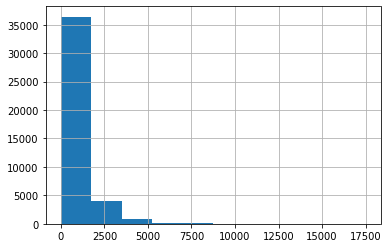

In [ ]:
urls_count.hist()

In [ ]:
df = df.query('url_host in @timur_url_list')

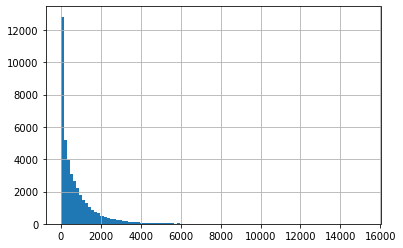

In [ ]:
df.groupby('user_id').agg('count')['url_host'].hist(bins=100)

# 3.ML

In [ ]:
#сабмиты и таргеты
id_for_target = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}').to_pandas().query ('age >=19 ')
id_for_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [ ]:
id_for_submit['user_id'].nunique()

144724

In [ ]:
id_for_target['user_id'].nunique()

268922

### Подгружаем файл с дииска
Трайн и сабмиты отдельно.   
Для age и is_male  отдельно.

In [ ]:
#df_train = pd.read_pickle(f'{LOCAL_DATA_PATH}/train_df_all_parts.pkl')
#df_train = pd.read_csv(f'{LOCAL_DATA_PATH}/train_df_all_parts.csv')   # csv  не подгруждается, не хватает памяти..


In [ ]:
df_submit = pd.read_feather(f'{LOCAL_DATA_PATH}/submit_df_all_parts.feather')
df_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144715 entries, 0 to 144714
Columns: 506 entries, cpe_model_name to zyf03k.xyz
dtypes: float64(504), int64(1), object(1)
memory usage: 558.7+ MB


In [ ]:
df_submit.loc[df_submit['cpe_model_name'].isna() ,'cpe_model_name'] = '0'

In [ ]:
df_submit.loc[df_submit['cpe_model_name'].isna() ,'cpe_model_name']

Series([], Name: cpe_model_name, dtype: object)

In [ ]:
df_submit = df_submit.drop(['user_id'], axis=1)

0         635.0
1         132.0
2         704.0
3          82.0
4         189.0
          ...  
144719      NaN
144720      NaN
144721      NaN
144722      4.0
144723      NaN
Name: morning, Length: 144724, dtype: float64

In [ ]:
# проверим размерности
#print ('df_train.shape =', df_train.shape)
print ('df_submit.shape =', df_submit.shape)

df_submit.shape = (144724, 2506)


###Трайн,Тест Сплит для тестов моделей

In [ ]:
################ age ###########

In [ ]:

#сшиваем куски 0 и  5(чтобы увеличить выборку под тесты) РАЗДЕЛЬНЫЙ сабмит
#df_train = pd.read_feather(f'{LOCAL_DATA_PATH}train_part_0.feather')
df_train = pd.read_feather(f'{LOCAL_DATA_PATH}train_age_part_0.feather')
print ('df_train.shape', df_train.shape)
#df_ = pd.read_feather(f'{LOCAL_DATA_PATH}train_part_5.feather')
df_ = pd.read_feather(f'{LOCAL_DATA_PATH}train_age_part_5.feather')
df_train = pd.concat([df_train, df_], ignore_index=True)
print ('df_train.shape', df_train.shape)

df_train.shape (27079, 1654)
df_train.shape (54040, 1654)


In [ ]:
#сшиваем куски 0 и  5(чтобы увеличить выборку под тесты) ОБЩИЙ сабмит
df_train = pd.read_feather(f'{LOCAL_DATA_PATH}train_part_0.feather')
print ('df_train.shape', df_train.shape)
df_ = pd.read_feather(f'{LOCAL_DATA_PATH}train_part_5.feather')
df_train = pd.concat([df_train, df_], ignore_index=True)
print ('df_train.shape', df_train.shape)

df_train.shape (15523, 2507)
df_train.shape (30844, 2508)


In [ ]:
# проверка городов на влияние на возраст
id_for_target = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}').to_pandas().query('age >=19 ') 
df_train = user_city.merge(id_for_target, on='user_id')
df_train['age'] = df_train['age'].map(age_bascket)

In [ ]:
id_for_target = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}').to_pandas().query('age >=19 ') 

In [ ]:
df_train.shape

(268922, 4)

In [ ]:
#cat_features = ['cpe_model_name'] #'cpe_manufacturer_name',
#cat_features = ['cpe_model_name', 'cpe_model_os_type']
cat_features = ['city']

In [ ]:
%%time
#тест модели  22 мин два куска по 2500 примрено
# 5000  33 мин
# 1200   12 min
x_train, x_test, y_train, y_test = train_test_split(\
    df_train.drop(['user_id', 'age', 'is_male'], axis = 1),   df_train['age'], test_size = 0.33, random_state = 777)
    #df_train.drop(['user_id', 'age', 'is_male', 'cpe_model_name',	'user_id',	'day',	'evening',	'morning',	'night'	], axis = 1), df_train['age'], test_size = 0.33, random_state = 777)

clf = CatBoostClassifier() #(task_type="GPU" , depth= 6, l2_leaf_reg=1, learning_rate=0.1)
clf.fit(x_train, y_train, cat_features=cat_features, verbose = False) #cat_features,
print(metrics.classification_report(y_test, clf.predict(x_test), \
    target_names = [ '19-25','26-34', '36-45', '46-56', '56-65', '65+']))

              precision    recall  f1-score   support

       19-25       0.50      0.00      0.00     10801
       26-34       0.32      0.94      0.48     28707
       36-45       0.30      0.07      0.11     25569
       46-56       0.12      0.00      0.00     14054
       56-65       0.00      0.00      0.00      7759
         65+       0.00      0.00      0.00      1855

    accuracy                           0.32     88745
   macro avg       0.21      0.17      0.10     88745
weighted avg       0.27      0.32      0.19     88745

CPU times: user 11min 44s, sys: 6.99 s, total: 11min 51s
Wall time: 7min 38s


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Обычный режим :      
CPU times: user 20min 12s, sys: 49.9 s, total: 21min 2s
Wall time: 13min 19s       
task_type="GPU" (с включением его в коллбае)      
CPU times: user 25.8 s, sys: 13.6 s, total: 39.5 s    
Wall time: 32.5 s      
 OMG!!! и метрики улучшились!!

In [ ]:
print(f1_score(y_test, clf.predict(x_test), average='weighted'))
age_f1 = f1_score(y_test, clf.predict(x_test), average='weighted')

0.1876616164382908


In [ ]:
#######  is MALE  ###########

In [ ]:
list_train_feat_is_male  = [
    'train_feat_is_male_part_0.feather',
    'train_feat_is_male_part_1.feather',
    'train_feat_is_male_part_2.feather',
    'train_feat_is_male_part_3.feather',
    'train_feat_is_male_part_4.feather',
    'train_feat_is_male_part_5.feather',
    'train_feat_is_male_part_6.feather',
    'train_feat_is_male_part_7.feather',
    'train_feat_is_male_part_8.feather',
    'train_feat_is_male_part_9.feather',
     ]

list_train_target_is_male  = [
    'train_target_is_male_part_0.csv',
    'train_target_is_male_part_1.csv',
    'train_target_is_male_part_2.csv',
    'train_target_is_male_part_3.csv',
    'train_target_is_male_part_4.csv',
    'train_target_is_male_part_5.csv',
    'train_target_is_male_part_6.csv',
    'train_target_is_male_part_7.csv',
    'train_target_is_male_part_8.csv',
    'train_target_is_male_part_9.csv',
     ]
#сшиваем куски 0 и  5(чтобы увеличить выборку под тесты) РАЗДЕЛЬНЫЙ САБМИТ
#цикл склейки train_feat_is_male для валидации

#первый файл
df = pd.read_feather(f'{LOCAL_DATA_PATH}{list_train_feat_is_male[0]}')
for i in range(1,10): #[5, 8]:
  df_ = pd.read_feather(f'{LOCAL_DATA_PATH}{list_train_feat_is_male[i]}')
  df = pd.concat([df, df_], ignore_index=True)
df_train_feat_is_male = df
print (df_train_feat_is_male.shape)

#цикл склейки train_target_is_male
#первый файл
df = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_target_is_male[0]}')
for i in  range(1,10): #[5, 8]:
  df_ = pd.read_csv(f'{LOCAL_DATA_PATH}{list_train_target_is_male[i]}')
  #сшиваем
  df = pd.concat([df, df_], ignore_index=True)
  
df_train_target_is_male = df
print (df_train_target_is_male.shape)

del df
del df_

(263488, 1610)
(263488, 1)


In [ ]:
#сшиваем куски 0 и  5(чтобы увеличить выборку под тесты) Общий САБМИТ
df_train = pd.read_feather(f'{LOCAL_DATA_PATH}train_part_0.feather')
print ('df_train.shape', df_train.shape)
df_ = pd.read_feather(f'{LOCAL_DATA_PATH}train_part_5.feather')
df_train = pd.concat([df_train, df_], ignore_index=True)
print ('df_train.shape', df_train.shape)

print(df_train['is_male'].unique())
df_train = df_train[df_train['is_male'] != 'NA']
print(df_train['is_male'].unique())

df_train.shape (15523, 2507)
df_train.shape (30844, 2508)


In [ ]:
# весь готовый  is_male подгружаем
df_train_feat_is_male = pd.read_feather(f'{LOCAL_DATA_PATH}train_feat_is_male_df_all_parts.feather').drop(['cpe_manufacturer_name'],axis=1)
df_train_target_is_male = pd.read_csv(f'{LOCAL_DATA_PATH}train_target_is_male_df_all_parts.csv')

In [ ]:
df_train_feat_is_male = df_train_feat_is_male[['city','cpe_model_name','cpe_model_os_type']]

In [ ]:
df_train_feat_is_male


,city,cpe_model_name,cpe_model_os_type
0,Санкт-Петербург,Galaxy S20+,Android
1,Новороссийск,Poco X3 Pro,Android
2,Тюмень,Redmi Note 8 Pro,Android
3,Нефтеюганск,Honor 10,Android
4,Пермь,Galaxy A40 Dual,Android
...,...,...,...
263483,Москва,iPhone 12,iOS
263484,Ливны,Honor 10,Android
263485,Москва,iPhone X,iOS
263486,Рыбинск,P Smart Z,Android


In [ ]:
cat_features = ['city']

In [ ]:
%%time
#cat_features = ['cpe_model_name'] #, 'cpe_manufacturer_name' , 'cpe_model_os_type'] 
#cat_features = ['cpe_model_name','cpe_model_os_type']
#cat_features = ['cpe_model_name', 'cpe_model_os_type','cpe_manufacturer_name', 'city']
#cat_features = ['cpe_model_name', 'cpe_model_os_type','city']
cat_features = ['city','cpe_model_name','cpe_model_os_type']

x_train, x_test, y_train, y_test = train_test_split(df_train_feat_is_male,\
    df_train_target_is_male, test_size = 0.33, random_state = 777)
#df_train[['cpe_model_name',	'user_id',	'day',	'evening',	'morning',	'night'	]], df_train['is_male'], test_size = 0.33, random_state = 777)

clf_2 = CatBoostClassifier () #(depth=6, l2_leaf_reg=1, learning_rate=0.12 )#
clf_2.fit(x_train, y_train, cat_features=cat_features, verbose = False ) 
print(f'GINI по полу {2 * metrics.roc_auc_score(y_test, clf_2.predict_proba(x_test)[:,1]) - 1:2.5f}')
del x_train
del x_test
del df_train_feat_is_male 

GINI по полу 0.14991
CPU times: user 2min 36s, sys: 3.85 s, total: 2min 40s
Wall time: 1min 35s


In [ ]:
feature_age_importance = pd.DataFrame(clf_2.get_feature_importance(), index=clf_2.feature_names_).reset_index()
feature_age_importance

,index,0
0,city,40.090323
1,cpe_model_name,40.132664
2,cpe_model_os_type,19.777014


GINI по полу 0.73685 на всей трайн-валид выборке с (depth=6, l2_leaf_reg=1, learning_rate=0.12 )     
GINI по полу 0.73413  на дефолтах   

GINI по полу 0.73489 на дефолтах  и cat_features = ['cpe_model_name', 'cpe_model_os_type','cpe_manufacturer_name', 'city']

In [ ]:
is_male_gini = 2 * roc_auc_score(y_test, clf_2.predict_proba(x_test)[:,1]) - 1
is_male_gini

NameError: ignored

In [ ]:
# GPU 0.4979827571553026
#  оыбч 0.5141124501715626 явно лучше

In [ ]:
#2 * f1_weighted(по 6 возрастным бакетам) + gini по полу.
# на всей выборке получается лучше на 0.1 примерно 0.41*2 + 0.668 = 1,488 ,а  мой скор на всей выборке 1,588
validation_score = 2 * age_f1 + is_male_gini
validation_score



1.5659287604778327

Итого тестов ( в бейз лане джини 0.665 , f1 w = 0.41)
1. Отсеяно окло 90 технич, топ 2500, с каждого куска отлетает 400, они оставлены , но везде по урлам у них NaN     
GINI по полу 0.668      
f1 weighted avg 0.40  

2. Отсеяно окло 124 технич(второй список тим), топ 2500, с каждого куска отлетает 430, они оставлены , но везде по урлам у них NaN     
GINI по полу 0.669      
f1 weighted avg 0.40 

3. как 2,только 0 и 5 часть
GINI по полу 0.684   
f1 weighted avg 0.41

4. Как 2 , только фрик изеров откинул. сразу пошло улчшение.   
GINI по полу 0.694   
f1 weighted avg 0.42
5. Обрезано 1500, фрик юзеры откинуты. Все таки уменьшается. Поэотму  нужно больше урлов.    
GINI по полу 0.691   
f1 weighted avg 0.41
6. взято 3000      как будто 2500 лучше зашло. попроубем снова
GINI по полу 0.691   
f1 weighted avg 0.41   

7. Возвращаем 2500       
f1 = 0.41652572833791973         
 0.6937536797756576        
 1.5268051364514972       
8.  2200     
 0.4215625331737689       
 0.6937223527878662   
 1.536847419135404      
9. 2000    
   1.5295346460897814    
10. тпеерь 2200 просто по топ урлам(просто без выкида технич), модель обучается дольше       
  0.42407319455382625      
  0.7137759046995946    
  1.561922293807247  
11. 3500 урлов(без выкида техн)       
 0.4237691751440371    
 0.7100425918188447  

12. только технические 124 шт     
 0.3888162737403301  
 0.5227557751781631 

13. всего 500    
 0.4171705859800364       
   0.6971221241586638     
   1.5314632961187367    

14. 500 после выкида технических. пол тоже хуже становится  
   0.6666198760291548     
15. 5000 без отсева техн  
 0.4232420184723813      
 0.7100330883738457

16. тупо откид первой сотни 100:2200    
  0.393738607432108      
  0.7053114477442413
17.2200, только урлы оставали без дня и ночи и модели тел.
  0.3817243605350264    тут отстает значит.
  0.6995905155436426 тут очень хорошо
18. Фичи импотантс_1 (от 2500 оставил не нулевые  веса фичи) age-1191 , male -1138)  
  0.4251173311022155      
  0.7147234246718353     
19. Фичи импотант 1_1 (прогонка на фич_имп_1 и отброс нулевых 230 и 150 примерно)    
  0.4242853084033863    
  0.7142319276812232  немного ухудшилось непонтно как себя поведет на всей выборке.  
20. как 19,только включил !!!!GPU в Кэт и Коллабе   
  0.42712763345063454      
  0.7014499770923197 немного ухудшилась еще..  надо проверить на всей выборке
21. фич_ип3(1+2 и снова фич имп на них)    
  cpe_modle_name     
  0.4280966038090383    
  0.7145228286492007   
  0.7145228286492007   GPU тоже самое чт ли ?       
   1.5707160362672772    
     

  cpe_modle_name+ manufactured    
  0.428814616718996   >>>>> 1 место! но тут нет топ скора на всем дс    
  0.7139946697686046      
  1.5716239032065966          
   
   cpe_modle_name+ manufactured +os_type    
  0.42523211526217675     
  0.7195595716180927   >>>>>>>>>1 место !!!!!  
  1.5700238021424462      

  'cpe_model_name','cpe_model_os_type'      
  0.42731406609825173      
  0.7034540717275477 GPU (точно)     
  .7197547395040331  без GPU     >>>>>>>>>1 место !!!!!     
  1.5743828717005366          

22. фич селект рандомом.1000 урлов топ.(но без GPU)       
  0.4255568199390758   
  0.7107815490375298     
  1.5618951889156814

22. фич селект рандомом.2000 урлов топ.(но без GPU)      
  0.41974817120480534    
  0.7100813993108459     
  1.5495777417204566        
23. фич селект рандомом.500 урлов топ.(но без GPU)      
  0.41755896277101173     
  0.7094910614526897
  1.5446089869947133   
24. фич селект рандомом.1200 урлов топ.(но без GPU)      
  0.42117353148381204     
  0.7111895226631166      
  1.5535365856307406
  
25. фич_слект_1+ фич_рандом_серч_топ_1200  (тут самый большой скор на всем дс)  
  0.42718752448217523      
  0.7115537115134822     
  1.5659287604778327  
26. фич_слект_1+ фич_рандом_серч_топ_1200 + грид серч   
{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}    
 0.42827795649469025   
   depth=6, l2_leaf_reg=1, learning_rate=0.13     
   0.7147781830159599  
   depth=6, l2_leaf_reg=1, learning_rate=0.12     
    0.7158738471713855

In [ ]:
0.428814616718996*2 + 0.7139946697686046

1.5716239032065966

In [ ]:
0.4280966038090383*2 + 0.7145228286492007

1.5707160362672772

### Значимость фичей.
Отобрать списки тока значимых ? те же 2200 тока значимых

In [ ]:
# подгружаем
#df_train_feat_age = pd.read_feather(f'{LOCAL_DATA_PATH}train_feat_age_df_all_parts.feather')
clf_age = joblib.load(f'{LOCAL_DATA_PATH}model_age_v13.pkl')

In [ ]:
# важные в дф и сорт по убыванию
feature_age_importance = pd.DataFrame(clf_age.get_feature_importance(), index=clf_age.feature_names_).reset_index()

# более лайтова запись, индексы из модели и и берем , ен надо мучатсья ))
#feature_importances = pd.Series(cat.feature_importances_, index=cat.feature_names_).sort_values(ascending=False)

In [ ]:
features_not_url_list = ['cpe_model_name', 'cpe_model_os_type',	'user_id',	'day',	'evening',	'morning',	'night']
feature_age_importance.shape


(1653, 2)

In [ ]:
feature_age_importance = feature_age_importance[feature_age_importance[0] > 0 ]
feature_age_importance.shape

(497, 2)

In [ ]:
feature_age_importance = feature_age_importance.sort_values(by=0, ascending=False).reset_index(drop=True)
#feature_age_importance = feature_age_importance.query('index not in@ features_not_url_list')
feature_age_importance.head(10)

,index,0
0,cpe_model_name,5.162622
1,vk.com,3.388008
2,l.instagram.com,2.957717
3,esia.gosuslugi.ru,2.898663
4,morning,2.458773
5,sun9-17.userapi.com,2.389039
6,whatsapp.com,2.221157
7,ad.adriver.ru,2.216849
8,sun9-29.userapi.com,2.187727
9,instagram.com,1.932699


In [ ]:
feature_age_importance.loc[feature_age_importance[0] == 0 ,0].shape

(0,)

In [ ]:
feature_age_importance.loc[feature_age_importance[0] > 0.1 ,0]

0      5.162622
1      3.388008
2      2.957717
3      2.898663
4      2.458773
         ...   
133    0.114965
134    0.114860
135    0.113294
136    0.108446
137    0.102733
Name: 0, Length: 138, dtype: float64

In [ ]:
#feature_age_not_importance_1 = feature_age_importance.loc[feature_age_importance[0] == 0 ,'index']
feature_age_importance_1 = feature_age_importance.loc[feature_age_importance[0] !=0 ,'index'] #<<<<
print ('feature_age_importance_1.shape',feature_age_importance_1.shape)
#print ('feature_age_not_importance_1.shape',feature_age_not_importance_1.shape)
#feature_age_not_importance_1.to_csv(f'{LOCAL_DATA_PATH}feature_age_not_importance_5.csv',index=False)
feature_age_importance_1.to_csv(f'{LOCAL_DATA_PATH}feature_age_importance_5.csv',index=False)

feature_age_importance_1.shape (1313,)


In [ ]:
#male  ПОДГРУЖАЕМ
#df_train_feat_is_male = pd.read_feather(f'{LOCAL_DATA_PATH}train_feat_is_male_df_all_parts.feather')
# load
clf_is_male = joblib.load(f'{LOCAL_DATA_PATH}model_is_male_v9.pkl')

In [ ]:
# важные в дф и сорт по убыванию
feature_male_importance = pd.DataFrame(clf_is_male.get_feature_importance(), index=clf_is_male.feature_names_).reset_index()

In [ ]:
feature_male_importance = feature_male_importance.sort_values(by=0, ascending=False).reset_index(drop=True)
feature_male_importance = feature_male_importance.query('index not in@ features_not_url_list')
feature_male_importance.head(10)

,index,0
0,syndication.realsrv.com,5.223595
1,baza.drom.ru,3.707607
2,i.pinimg.com,3.390719
3,l.instagram.com,2.790935
4,rpc-php.trafficfactory.biz,2.287600
5,drive2-ru.turbopages.org,2.033468
6,s-cdn.sportbox.ru,1.842507
7,avatars.mds.yandex.net,1.361886
8,drive2.ru,1.348615
9,i.ytimg.com,1.212685


In [ ]:
feature_male_importance.loc[feature_male_importance[0] == 0 ,0].shape


(529,)

In [ ]:
feature_male_importance.loc[feature_male_importance[0] > 0 ,0].shape

(1075,)

In [ ]:
# сохраняем важные и не важные  фичи на диск
#feature_male_not_importance_1 = feature_male_importance.loc[feature_male_importance[0] == 0 ,'index']
feature_male_importance_1 = feature_male_importance.loc[feature_male_importance[0] > 0 ,'index'] # <<<<<<<<
print ('feature_male_importance_1.shape',feature_male_importance_1.shape)
#print ('feature_male_not_importance_1.shape',feature_male_not_importance_1.shape)
#feature_male_not_importance_1.to_csv(f'{LOCAL_DATA_PATH}feature_male_not_importance_4.csv', index=False)
feature_male_importance_1.to_csv(f'{LOCAL_DATA_PATH}feature_male_importance_5.csv',index=False)

feature_male_importance_1.shape (1075,)


In [ ]:
# 1 это выжимка из 2500 топ урлов не нулевые, ~ 1200 shape
# 1_1 прогонка 1 (с улучшением метрики), не нулевые ~ 943 age shape, 1009 male.shape
# 2 выжимка из 2500-5000 урлвов 1473 age, 1135 age
# 3 это обьеденение 1 и 2 и выжимка из них фич_имп 
# 4 
# 5 фич имп 1 +фич_рандом_серч_топ1200   выжимка   ~~ 1300_age  , ~~~~1075+male (тут самый лучший скор получился ,без выжимки еще )
# 6
# 
#f'{LOCAL_DATA_PATH}feature_age_not_importance_1.csv'
#f'{LOCAL_DATA_PATH}feature_age_importance_1.csv'

### Грид серч ?

In [ ]:
cat_features = ['cpe_model_name', 'cpe_model_os_type']

In [ ]:
clf = CatBoostClassifier(task_type="GPU",cat_features=cat_features)
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
grid_search_results = clf.grid_search(grid, df_train.drop(['user_id', 'age', 'is_male'], axis = 1),   df_train['age'], shuffle=False, verbose=False, plot=False)

In [ ]:
grid_search_results['params']
#{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
#немного улучшило метрику на age на валид , можно поробовать около этих параметров искать
#

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [ ]:
%%time
clf = CatBoostClassifier(cat_features=cat_features, silent=True)
grid = {
    'learning_rate': [0.115, 0.12, 0.125],
    'depth':[6],
    'l2_leaf_reg': [1],
    #'bootstrap_type':['Bayesian' , 'Bernoulli'],
    #'bagging_temperature': [0, 1, 10]

}
grid_search_results = clf.grid_search(grid, df_train_feat_is_male,   df_train_target_is_male, shuffle=False, verbose=False, plot=False)


bestTest = 0.5057333952
bestIteration = 982


bestTest = 0.5049161977
bestIteration = 998


bestTest = 0.5058939816
bestIteration = 998

Training on fold [0/3]

bestTest = 0.4675397812
bestIteration = 999

Training on fold [1/3]

bestTest = 0.4671721857
bestIteration = 999

Training on fold [2/3]

bestTest = 0.4706967334
bestIteration = 993

CPU times: user 1h 8min 13s, sys: 2min 30s, total: 1h 10min 43s
Wall time: 43min 16s


In [ ]:
grid_search_results['params']
#{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.12}
#{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.12}
# {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.12, 'bootstrap_type': 'Bernoulli'} бернули ухудшает по сравнениюс дефолтом
#{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.12}

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.12}

## ML age

In [ ]:
# загружаем файл для age
#df_train_feat_age = pd.read_feather(f'{LOCAL_DATA_PATH}train_feat_age_df_all_parts.feather')
#df_train_target_age = pd.read_csv(f'{LOCAL_DATA_PATH}train_target_age_df_all_parts.csv')



In [ ]:
#cat_features = ['cpe_manufacturer_name',	'cpe_model_os_type' ] #	,
cat_features = ['cpe_model_name'] 


### Обучение на всей трайн выборке для сабмитов

In [ ]:
# подгружаем
df_train_feat_age = pd.read_feather(f'{LOCAL_DATA_PATH}train_feat_age_df_all_parts.feather')
df_train_target_age = pd.read_csv(f'{LOCAL_DATA_PATH}train_target_age_df_all_parts.csv')

In [ ]:
#cat_features = ['cpe_model_name'] 
#cat_features = ['cpe_model_name', 'cpe_model_os_type']
cat_features = ['cpe_model_name','city']

In [ ]:
df_train_feat_age['cpe_model_os_type']

0         0
1         0
2         0
3         0
4         0
         ..
268893    1
268894    0
268895    1
268896    0
268897    0
Name: cpe_model_os_type, Length: 268898, dtype: int64

In [ ]:
%%time
# финальное обучение для сабмита age
#Wall time: 1h 38min 10s для 1к с чем то урлов
# 2500 урлов на GPU 3 мин вместо 3,5 часа ан обычном
clf = CatBoostClassifier(task_type="GPU" ) #,depth= 6, l2_leaf_reg=1 )
clf.fit(df_train_feat_age, df_train_target_age, cat_features, verbose = False)



CPU times: user 1min 6s, sys: 27.3 s, total: 1min 34s
Wall time: 1min 26s


In [ ]:
##########################
# SAVE-LOAD using joblib #
##########################
# v5 features important_1
# v5.1 features important_1   age на GPU
# v6 второй кусок 2500-5000 топ урлов 
# v7 фич_имп_1+2
# v8 фич_имп_3 (отжим 1+2) надо отправить 
# v9 5001-7500 для фич выжимки
# v10 фич_имп с помощью рандом-цикла, топ 1200
# v11 eatures important_1_1 на ГПЮ
# v12 как 11только age<19 оставил в трайн выборке
# v13 'Это фич_имп_1 | фич_рандом_сейрч_топ 1200
# v 14это  v13+ города + прозвод телефона + параметры
# v15 это как 14 только на дефолтах для проверки скора
# v16 выжимка из (фич_имп_1 | фич_рандом_сейрч_топ 1200), ос как 0 и 1, города
joblib.dump(clf, f'{LOCAL_DATA_PATH}model_age_v16.pkl')

['/content/drive/MyDrive/DS/MTS/model_age_v16.pkl']

In [ ]:
del df_train_feat_age
del df_train_target_age

In [ ]:
# load
clf_age = joblib.load(f'{LOCAL_DATA_PATH}model_age_v16.pkl')

In [ ]:
# предикты возраста для  раздельного сабмита
df_submit_age = pd.read_feather(f'{LOCAL_DATA_PATH}/submit_age_df_all_parts.feather')
predict_age = clf_age.predict(df_submit_age.drop(['user_id'],axis=1))


In [ ]:
#for i in cat_features:
#  df_submit_age.loc[df_submit_age[i].isna() ,i] = '0'


In [ ]:
# для совмещенного сабмит 
df_submit = pd.read_feather(f'{LOCAL_DATA_PATH}/submit_df_all_parts.feather')
predict_age = clf_age.predict(df_submit)

In [ ]:
print(predict_age.shape)
print(df_submit_age['user_id'].shape)

(144719, 1)
(144719,)


## ML is_male


### Обучение на всей выбоке для сабмитов

In [ ]:
df_train_feat_is_male = pd.read_feather(f'{LOCAL_DATA_PATH}train_feat_is_male_df_all_parts.feather')
df_train_target_is_male = pd.read_csv(f'{LOCAL_DATA_PATH}train_target_is_male_df_all_parts.csv')

In [ ]:
#cat_features = ['cpe_model_name'] 
#cat_features = ['cpe_model_name', 'cpe_model_os_type']
cat_features = ['cpe_model_name', 'city']

In [ ]:
%%time
# обучения для сабмита на всей выборке
clf = CatBoostClassifier () #(depth=6, l2_leaf_reg=1, learning_rate=0.12 )
clf.fit(df_train_feat_is_male, df_train_target_is_male, cat_features , verbose = False )


CPU times: user 25min 10s, sys: 16.7 s, total: 25min 27s
Wall time: 14min 57s


In [ ]:
##########################
# SAVE-LOAD using joblib #
##########################
# v5 features important_1 (~~~1200)
# v5.
# v6 второй кусок 2500-5000 топ урлов 
# v7 фич имп 1+2 
# v8 (1+2).faeat_imp
# v9 5001-7500
# v10  фич имп  рандом топ 1200
joblib.dump(clf, f'{LOCAL_DATA_PATH}model_is_male_v16.pkl')


['/content/drive/MyDrive/DS/MTS/model_is_male_v16.pkl']

In [ ]:
del df_train_feat_is_male
del df_train_target_is_male

In [ ]:
# load
clf_is_male = joblib.load(f'{LOCAL_DATA_PATH}model_is_male_v16.pkl')

In [ ]:
# для раздельного сабмит age &  male
df_submit_male = pd.read_feather(f'{LOCAL_DATA_PATH}/submit_male_df_all_parts.feather')
predict_is_male_proba = clf_is_male.predict_proba(df_submit_male.drop(['user_id'],axis=1))


In [ ]:
# для совмещенного  сабмит age &  male
df_submit= pd.read_feather(f'{LOCAL_DATA_PATH}/submit_df_all_parts.feather')
predict_is_male_proba = clf_is_male.predict_proba(df_submit)

In [ ]:
predict_is_male_proba[:,0].shape

(144723,)

In [ ]:
df_submit_male['user_id'].shape

(144723,)

## Заполняем id_to_submit

In [ ]:
#это временный дата сет, т к у нас нет некоторого числа user_id  
a = pd.DataFrame (df_submit_age['user_id'])
b = pd.DataFrame (df_submit_male['user_id'])
#раздельно
a['age'] =  predict_age
b['is_male'] = predict_is_male_proba[:,1]

In [ ]:
a['user_id'].value_counts().head(5)

45098     1
361153    1
11961     1
35203     1
269706    1
Name: user_id, dtype: int64

In [ ]:
print (b[b['user_id'] == 406224].index)
print (b[b['user_id'] == 85148].index)
print (b[b['user_id'] == 53540].index)


Int64Index([117215, 117216], dtype='int64')
Int64Index([45169, 45170], dtype='int64')
Int64Index([61186, 61187], dtype='int64')


In [ ]:
# какие то полные дубликаты залетели 3 шт...появились посл е добавления os_type
a = a.drop_duplicates()
b = b.drop_duplicates()

In [ ]:
b = b.drop(index=[117215])
b = b.drop(index=[45169])
b = b.drop(index=[61186])

In [ ]:
#совмещно
a = pd.DataFrame (df_submit['user_id'])
a['age'] =  predict_age
a['is_male'] = predict_is_male_proba[:,1]

NameError: ignored

In [ ]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas().reset_index(drop=True)
id_to_submit.shape

(144724, 1)

In [ ]:
# когда все user_id  в предиктах
#id_to_submit['is_male'] = predict_is_male_proba[:,1]
#id_to_submit['age'] =  predict_age

In [ ]:
#этот мердж правльный РАЗДЕЛЬНЫЙ сабмит
id_to_submit = id_to_submit.merge(a,how='outer', on='user_id')
id_to_submit = id_to_submit.merge(b,how='outer', on='user_id')

In [ ]:
id_to_submit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144724 entries, 0 to 144723
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  144724 non-null  int64  
 1   age      144715 non-null  float64
 2   is_male  144709 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 4.4 MB


In [ ]:
#заполним пропуски is_male = 0.511735 , age = 2 or 3

In [ ]:
#закрывем na
id_to_submit.loc[id_to_submit['age'].isna(),'age'] = 2
id_to_submit.loc[id_to_submit['is_male'].isna(),'is_male'] = 0.50
id_to_submit['age'] = id_to_submit['age'].astype(int)

In [ ]:
#144724 
id_to_submit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144724 entries, 0 to 144723
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  144724 non-null  int64  
 1   age      144724 non-null  int64  
 2   is_male  144724 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.4 MB


In [ ]:
id_to_submit.head()

,user_id,age,is_male
0,221301,2,0.930607
1,31271,3,0.498271
2,211594,2,0.550373
3,253119,3,0.513407
4,192578,2,0.832978


In [ ]:
#итоговый сохраняем
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission_v16.csv', index = False)
# v8 надо потправить, пофиксенную я сохранил

In [ ]:
del df_submit_age
del df_submit_male

## СКоры на лидер борде    
Когда пофиксил категоризацию age
	1,6359491017   это 2300 тпо урлов без отсева технических, кэт дефол          
	1,5881700832 отсеяно окло 100 технич, топ 2500, с каждого куска отлетает 400, я их оставил, похоже их нужно отдельно обрабатывать      

	1,6366998198 2500 урлов с техническими   
	
	1,652348507 начал отжимать фич импотант и на GPU
	


	1,6539579536 v13 овместил фич_имп1+фич_рандом_серч_топ_1200